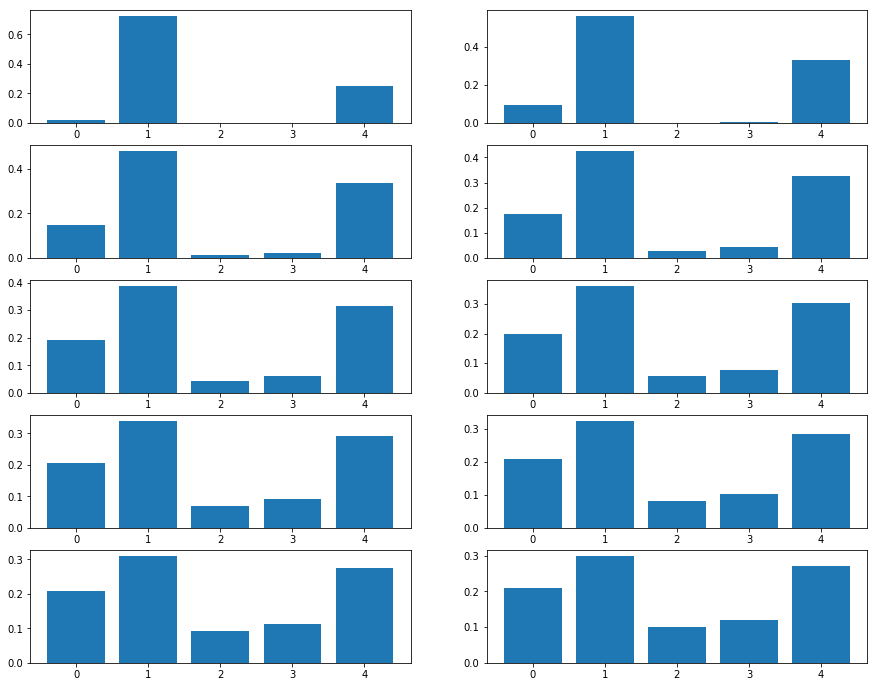

In [34]:
import numpy as np
import matplotlib.pyplot as plt
#对不同的softmax温度，对概率分布进行重新加权
def reweight_distribution(original_distribution, temperature=0.5):
    '''
    original_distribution是原始分布，是概率值组成的一维np数组，和为1。
    temperature，它更大，得到熵更大的分布，生成更加出人意料的生成数据；
    更小，对应随机性更小，生成更加可预测的生成数据。
    '''
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)
#画图
distribution = np.array([0.21, 0.3, 0.1, 0.12, 0.27])
fig,ax = plt.subplots(5,2,figsize=(15,12));
temperature = 0.1
for row in range(5):
    for col in range(2):
        #print(temperature)
        #生成分布
        distr = reweight_distribution(distribution, temperature)
        ax[row][col].bar(np.arange(len(distr)),distr)
        #plt.title('temperature=%.2f' %temperature)
        temperature += 0.1

In [38]:
import keras
import numpy as np

Using TensorFlow backend.


In [39]:
#下载并解析初始文本文件
path = keras.utils.get_file('nietzsche.txt',
                           origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Corpus length:', len(text))

606208/600901 [==============================] - 3s 5us/step
Corpus length: 600893


In [40]:
text[:100]

'preface\n\n\nsupposing that truth is a woman--what then? is there not ground\nfor suspecting that all ph'

In [48]:
#将字符序列向量化
'''
提取长度为maxlen的序列，对他们进行one-hot编码，
打包成（sequences,maxlen,unique_charactors）三维np数组；
准备对应序列的标签（sequences,unique_charactors）二维np数组。
'''
maxlen = 60 #提取60个字符组成的序列
step = 3 #每3个字符采样一个新序列
sentences = [] #保存所提取的序列
next_chars = [] #保存目标（即下一个字符）

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i:i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

chars = sorted(list(set(text))) #语料中唯一字符组成的列表
print('Unique characters:', len(chars))
char_indices = dict((char, chars.index(char)) for char in chars)
#char_indices

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[char]] = 1
print('finish vectorization!')    
#print(x, '\n', y)

Number of sequences: 200278
Unique characters: 57
Vectorization...
finish vectorization!


In [49]:
from keras import layers
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.


In [50]:
#给定模型,采样下一个字符的函数
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [1]:
import random
import sys

for epoch in range(1, 60):
    print('epoch', epoch)
    #将模型在数据上拟合一次
    model.fit(x, y, batch_size=128, epochs=1)
    #随机选择一个文本种子
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('----Genrating with seed:' + '"' + generated_text + '"')
    #尝试不同采样温度
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('----temperature:', temperature)
        sys.stdout.write(generated_text)
        
        for i in range(400):
            #生成字符one-hot编码
            sampled = np.zeros((1, maxlen, len(chars))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.
            #对下一个字符进行采样
            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            
            generated_text += next_char
            generated_text = generated_text[1:]
            
            sys.stdout.write(next_char)

SyntaxError: invalid syntax (<ipython-input-1-966c1e4cbc5f>, line 20)